# Reads an image from a webcam, sends to the cloud (MS Cognitive Services) and returns useful information.

## Emotion: *emotions expressed by one or more people in an image, as well as returns a bounding box for the face(happiness, sadness, surprise, anger, fear, contempt, and disgust or neutral)* 
## Analise: *extracts a rich set of visual features based on the image content.* 
## Description: *generates a description of an image in human readable language with complete sentences.*


Based on https://github.com/Microsoft/Cognitive-emotion-python

In [1]:
import cv2
import time
import os

# https://github.com/ricardodeazambuja/Webcam2HTTP
from Webcam2HTTP import snapshot_generator

In [3]:
#
# Testing snapshot_generator
#

import numpy
import matplotlib.pyplot as plt
%matplotlib inline

snp = snapshot_generator()

Device initialised, ready to capture!


In [11]:
img = snp() # In my laptop, the camera takes a while until it adapts 
            # to the lighting conditions and a second shot is always necessary...

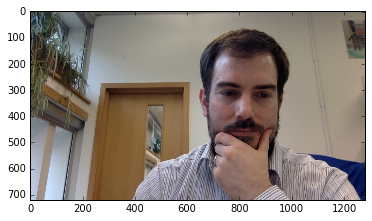

In [12]:
plt.imshow(cv2.imdecode(numpy.frombuffer(img,dtype = numpy.uint8), cv2.cv.CV_LOAD_IMAGE_COLOR))
plt.show()

In [13]:
snp(False)

Device closed, exiting...


0

In [32]:
# Variables

_url_emotion = 'https://westus.api.cognitive.microsoft.com/emotion/v1.0/recognize'
_url_vision_analise = 'https://westus.api.cognitive.microsoft.com/vision/v1.0/analyze'
_url_vision_describe = 'https://westus.api.cognitive.microsoft.com/vision/v1.0/describe'

_maxNumRetries = 10


_key_vision = 'f1642abeaa6f46dfa6f40c7363a36f09' #Here you have to paste your primary key (mine is invalid now...)
_key_emotion = '13b4f4e393d942088014152be726f61a' #Here you have to paste your primary key (mine is invalid now...)

## Helper functions

In [12]:
import time 
import requests

def processRequest( json, data, headers, params, _url):

    """
    Helper function to process the request to Project Oxford

    Parameters:
    json: Used when processing images from its URL. See API Documentation
    data: Used when processing image read from disk. See API Documentation
    headers: Used to pass the key information and the data type request
    """

    retries = 0
    result = None

    while True:

        response = requests.request( 'post', _url, json = json, data = data, headers = headers, params = params )

        if response.status_code == 429: 

            print( "Message: %s" % ( response.json()['error']['message'] ) )

            if retries <= _maxNumRetries: 
                time.sleep(1) 
                retries += 1
                continue
            else: 
                print( 'Error: failed after retrying!' )
                break

        elif response.status_code == 200 or response.status_code == 201:

            if 'content-length' in response.headers and int(response.headers['content-length']) == 0: 
                result = None 
            elif 'content-type' in response.headers and isinstance(response.headers['content-type'], str): 
                if 'application/json' in response.headers['content-type'].lower(): 
                    result = response.json() if response.content else None 
                elif 'image' in response.headers['content-type'].lower(): 
                    result = response.content
        else:
            print( "Error code: %d" % ( response.status_code ) )
            print( "Message: %s" % ( response.json()['error']['message'] ) )

        break
        
    return result

In [5]:
import cv2
import operator

def renderResultOnImage( result, img ):
    
    """Display the obtained results onto the input image"""
    
    for currFace in result:
        faceRectangle = currFace['faceRectangle']
        cv2.rectangle( img,(faceRectangle['left'],faceRectangle['top']),
                           (faceRectangle['left']+faceRectangle['width'], faceRectangle['top'] + faceRectangle['height']),
                       color = (255,0,0), thickness = 5 )


    for currFace in result:
        faceRectangle = currFace['faceRectangle']
        currEmotion = max(currFace['scores'].items(), key=operator.itemgetter(1))[0]


        textToWrite = "%s" % ( currEmotion )
        cv2.putText( img, textToWrite, (faceRectangle['left'],faceRectangle['top']-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255,0,0), 1 )

# Detect faces from a webcam (and emotions)

Device initialised, ready to capture!
[{u'faceRectangle': {u'width': 293, u'top': 244, u'left': 609, u'height': 293}, u'scores': {u'sadness': 0.060472168, u'neutral': 0.9374142, u'contempt': 0.000872500765, u'disgust': 0.0003725337, u'anger': 0.0007416295, u'surprise': 9.548205e-05, u'fear': 9.465442e-06, u'happiness': 2.20154961e-05}}]
Device closed, exiting...


0

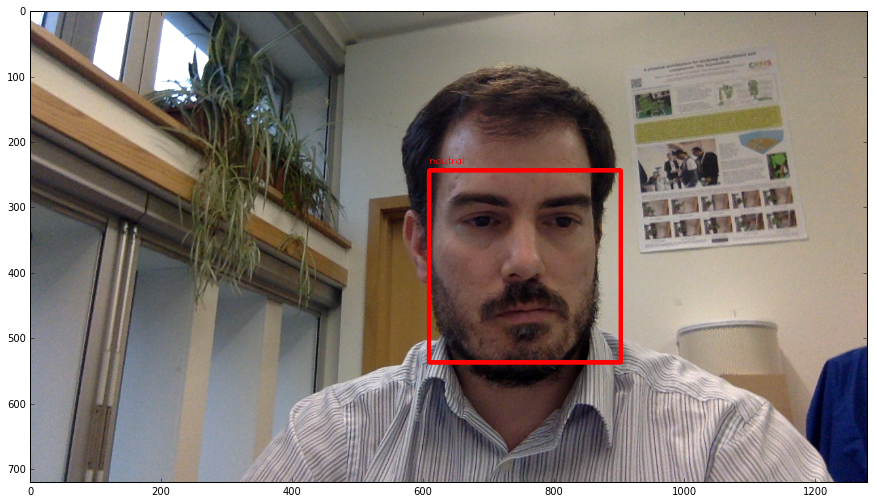

In [13]:
snp = snapshot_generator() # initialises the system

data = snp() # grabs the image from your device

headers = dict()
headers['Ocp-Apim-Subscription-Key'] = _key_emotion
headers['Content-Type'] = 'application/octet-stream'

json = None
params = None

result = processRequest( json, data, headers, params, _url_emotion)

# Debug
print result

if result is not None:
    # Load the original image
    data8uint = numpy.fromstring( data, numpy.uint8 ) # Convert string to an unsigned int array
    img = cv2.imdecode( data8uint, cv2.IMREAD_COLOR )

    renderResultOnImage( result, img )

    ig, ax = plt.subplots(figsize=(15, 20))
    ax.imshow( img )
    

snp(False) # closes the device

# Analises an Image from a webcam

In [52]:
snp = snapshot_generator() # initialises the system

data = snp() # grabs the image from your device

headers = dict()
headers['Ocp-Apim-Subscription-Key'] = _key_vision
headers['Content-Type'] = 'application/octet-stream'

json = None

params = {'visualFeatures': 'Categories,Tags,Description,Faces,ImageType,Color,Adult', 'language': 'en'}

result = processRequest( json, data, headers, params, _url_vision_analise)

# Debug
print result
    

snp(False) # closes the device

Device initialised, ready to capture!
{u'description': {u'captions': [{u'text': u'a man in a shirt and tie', u'confidence': 0.3492756693754644}], u'tags': [u'person', u'man', u'indoor', u'front', u'looking', u'camera', u'shirt', u'table', u'wearing', u'posing', u'holding', u'glasses', u'standing', u'sitting', u'food', u'smiling', u'large', u'young', u'white', u'blue', u'sign']}, u'adult': {u'isAdultContent': False, u'racyScore': 0.05631778761744499, u'adultScore': 0.09381381422281265, u'isRacyContent': False}, u'tags': [{u'confidence': 0.9996374845504761, u'name': u'person'}, {u'confidence': 0.9959867596626282, u'name': u'man'}, {u'confidence': 0.8599823117256165, u'name': u'indoor'}, {u'confidence': 0.39076122641563416, u'name': u'posing'}], u'color': {u'accentColor': u'653427', u'dominantColorForeground': u'Grey', u'dominantColorBackground': u'Grey', u'dominantColors': [u'Grey'], u'isBWImg': False}, u'requestId': u'515ed390-a1c3-41da-8e89-ff069a30abf7', u'faces': [{u'gender': u'Male'

0

In [53]:
snp = snapshot_generator() # initialises the system

data = snp() # grabs the image from your device

headers = dict()
headers['Ocp-Apim-Subscription-Key'] = _key_vision
headers['Content-Type'] = 'application/octet-stream'

json = None

params = {'maxCandidates': '1'}

result = processRequest( json, data, headers, params, _url_vision_describe)

# Debug
print result

snp(False) # closes the device

Device initialised, ready to capture!
{u'metadata': {u'width': 1280, u'format': u'Png', u'height': 720}, u'description': {u'captions': [{u'text': u'a man looking at the camera', u'confidence': 0.48562810057120676}], u'tags': [u'person', u'man', u'indoor', u'front', u'looking', u'camera', u'table', u'wearing', u'shirt', u'standing', u'holding', u'posing', u'glasses', u'sitting', u'food', u'black', u'young', u'large', u'white', u'blue', u'sign']}, u'requestId': u'7d33134c-72b4-4329-a531-9d78702fcb28'}
Device closed, exiting...


0